# Combatting Partisan Homogenization in New Content Recommenders - Baseline

# Main Components

### Part 1 : Topic Clustering and Recommender Performance for Homogeneous and Heterogeneous Users

1) Data Loading  
2) Sampling  
3) Text Preprocessing  
4) Vectorization  
5) Dimensionality Reductions  
6) Clustering  
7) Clustering Performance Check  
8) Cluster Filtering  
9) Pairwise Selection  
10) Model Training and Performance  
11) Pairwise score analysis

### Part 2: Online Learning Setting
1) Partial Fit Models  
2) Varying Number of Recommendations vs Precision and Recall for Homogenous and Heterogeneous Users  
2) Model Performance Analysis  

#### Important:
* Heterogenous User:
    * Conservative on Cluster 1 but Liberal on Cluster 2
* Homogeneous User:
    * Conservative on Cluster 1 and Cluster 2

In [39]:
import os
from collections import Counter,defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import re
import seaborn as sns
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn import metrics
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV,SGDClassifier,PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale
import joblib
from joblib import Parallel, delayed
from functools import wraps
from time import time
import itertools
from functools import partial
import functools
import time
import warnings

In [40]:
warnings.filterwarnings('ignore')

In [41]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [42]:
np.random.seed(24101990)
RANDOM_SEED = np.random.randint(low=1, high=100000, size=1)[0]
print("Random_Seed Chosen : %s" %str(RANDOM_SEED))

Random_Seed Chosen : 15112


In [66]:
def timer(func):
    """
    Decorator to time a given function

    Parameters
    ----------
    func : generic
        The function to time

    Raises
    ------
    No Exceptions

    Returns
    -------
    value : generic
        The return value from func

    """
    @functools.wraps(func)
    def wrapper_timer(*args,**kwargs):
        start = time.perf_counter()
        value = func(*args,**kwargs)
        stop = time.perf_counter()
        run_time = stop - start
        print(f"\nFinished running {func.__name__!r} in {run_time/60.0:.4f} mins\n")
        return value
    return wrapper_timer

@timer
def preprocess_texts(text_lists):
    """
    """
    
    def select_first10(x):
        return " ".join(sent_tokenize(x)[:10])
    
    def to_lower(x):
        return x.lower()
    
    def remove_punc(x):
        return re.sub(r'[^\w\s]', '  ', x)
    
    def remove_small_words(x):
        return re.sub(r'\b\w{1,2}\b', '', x)
    
    def remove_spaces(x):
        return re.sub(' +', ' ', x)
    
    preprocess_pipe = [select_first10,to_lower,remove_punc,remove_small_words,remove_spaces]
    
    processed_texts = text_lists
    for preprocess_func in preprocess_pipe:
        print("Running : %s" %str(preprocess_func.__name__))
        processed_texts = Parallel(n_jobs=-1)(delayed(preprocess_func)(x) for x in processed_texts)

    return processed_texts

@timer
def load_data(path):
    """
    """
    df = pd.read_csv(path)
    print(df.columns)
    print("Df original shape : %s" %str(df.shape))
    # drop rows with text as nan
    df = df[df['text'].notna()]
    print("Df shape after dropping nan text : %s" %str(df.shape))
    # drop articles that have stance = 0
    df = df[df["source_partisan_score"] != 0]
    print("Df shape after dropping 0 stance articles : %s" %str(df.shape))
    # convert articles of stance -1,+1,-2,+2
    df["binary_ps"] = df["source_partisan_score"].apply(lambda x: 1 if x>=1 else 0)
    
    return df

@timer
def sample_data(df,sample_size=0.2,seed=RANDOM_SEED):
    """
    """
    return df.sample(frac=sample_size, replace=False, random_state=seed)

@timer
def vectorization(df,min_df=30,max_df=0.75,seed=RANDOM_SEED):
    """
    """
    df["all_text"] = df["title"] + " " + df["processed_text"]
    tfidf_vectorizer = TfidfVectorizer(min_df=min_df, binary=False, max_df=max_df, stop_words='english')
    vectors = tfidf_vectorizer.fit_transform(df["all_text"])
    vocab = tfidf_vectorizer.vocabulary_
    print("vocab_size : %s"%str(len(vocab)))
    return vectors,vocab,tfidf_vectorizer

@timer
def dimensionality_reduction(vectors,mode="PCA",dim=500,seed=RANDOM_SEED):
    """
    """
    print("\nShape Before DIM REDUC : %s" %str(vectors.shape))
    if mode == "PCA":
        pca = PCA(n_components=dim,svd_solver="arpack",random_state=seed)
        vectors = pca.fit_transform(vectors.todense())
        print("Shape After DIM REDUC : %s" %str(vectors.shape))
        return vectors
    if mode == "SVD_LSA":
        tsvd = TruncatedSVD(n_components=dim,algorithm="arpack",random_state=seed)
        vectors = tsvd.fit_transform(vectors)
        print("Shape After DIM REDUC : %s" %str(vectors.shape))
        return vectors
    
    if mode == "UMAP":
        return None

@timer
def run_clustering(vectors,seed=RANDOM_SEED,num_clusters=1000,clus_type="kmeans"):
    """
    """
    if clus_type == "kmeans":
        print("\nRunning KMEANS Clustering with k=%s" %str(num_clusters))
        km = MiniBatchKMeans(n_clusters=num_clusters, random_state=seed, n_init=3, max_iter=200, batch_size=1000)
        clusters = km.fit_predict(vectors)
        return clusters,km
    
    if clus_type == "spectral":
        return None
    
    if clus_type == "dbscan":
        return None

@timer
def get_cluster_sizes(cluster_clf):
    """
    """
    cluster_sizes = Counter(cluster_clf.labels_)
    return cluster_sizes

@timer
def score_cluster(vectors,cluster_clf,score_type="sil_score"):
    """
    """
    if score_type == "sil_score":
        sil_score = metrics.silhouette_score(vectors, cluster_clf.labels_, metric='euclidean')
        print("\nSilhouetter Score : %s" %str(sil_score))
        return sil_score
    
    return None

@timer
def get_cluster_pairs(num_clusters):
    """
    """
    cluster_pairs = list(itertools.combinations(range(num_clusters), 2))
    print("\nNumber of Cluster Pairs : %s" %str(len(cluster_pairs)))
    return cluster_pairs

@timer
def get_pairwise_dist(cluster_clf,dist_type="cosine"):
    """
    """
    pairwise_dist = None
    if dist_type == "cosine":
        pairwise_dist = cosine_similarity(cluster_clf.cluster_centers_)
    return pairwise_dist

@timer
def cluster2doc(num_texts,cluster_labels):
    """
    """
    cluster_2_doc = defaultdict(list)
    for index in range(num_texts):
        cluster = cluster_labels[index]
        cluster_2_doc[cluster].append(index)
    return cluster_2_doc


@timer
def filter_clusters(cluster_pairs,
                    doc_2_cluster_map,
                    cluster_sizes,
                    partisan_scores,
                    min_size=300,
                    max_size=5000,
                    min_partisan_size=0.3):
    """
    min_partisan_size : percentage of docs in the cluster that must have partisan score of 0 (and similarly 1), this removes pure clusters as well
    """

    def get_cluster_partisan_map(doc_2_cluster_map,partisan_scores):
        """
        """
        cluster_partisan_map = defaultdict(int)
        for cluster in doc_2_cluster_map:
            ps_scores = []
            for doc_id in doc_2_cluster_map[cluster]:
                ps_scores.append(partisan_scores[doc_id])
            cluster_partisan_map[cluster]=ps_scores
        
        return cluster_partisan_map
    
    cluster_partisan_map = get_cluster_partisan_map(doc_2_cluster_map,partisan_scores)
    
    def filter_min_max(cluster_pair,cluster_sizes):
        """
        Boolean Func
        """
        verdict = True
        cond1 = cluster_sizes[cluster_pair[0]] >= min_size and cluster_sizes[cluster_pair[0]] <= max_size 
        cond2 = cluster_sizes[cluster_pair[1]] >= min_size and cluster_sizes[cluster_pair[1]] <= max_size 
        if cond1 == True and cond2 == True:
            verdict = False
        
        return verdict
    
    partial_filter_min_max = partial(filter_min_max,cluster_sizes=cluster_sizes)
    
    def filter_partisan_size(cluster_pair,min_partisan_size,cluster_sizes,cluster_partisan_map):
        """
        Boolean Func
        takes a cluster pair and checks the partisan distribution compaired to its cluster size
        
        """
        conds = [True,True]
        for i,c in enumerate(cluster_pair):
            cluster_partisan = cluster_partisan_map[c]
            partisan_size = Counter(cluster_partisan)
            if partisan_size[0] >= int(cluster_sizes[c]*min_partisan_size) and partisan_size[1] >= int(cluster_sizes[c]*min_partisan_size):
                conds[i] = False
        
        if conds[0] == conds[1] == False:
            return False
        else:
            return True

    
    partial_filter_partisan_size = partial(filter_partisan_size,min_partisan_size=min_partisan_size,
                                                                cluster_sizes=cluster_sizes,
                                                                cluster_partisan_map=cluster_partisan_map)
    
    filter_verdicts_min_max = Parallel(n_jobs=-1)(delayed(partial_filter_min_max)(c_p) for c_p in cluster_pairs)
    filter_verdicts_partisan_size = Parallel(n_jobs=-1)(delayed(partial_filter_partisan_size)(c_p) for c_p in cluster_pairs)
    
    filtered_cps = []
    for index,cp in enumerate(cluster_pairs):
        if not filter_verdicts_min_max[index] and not filter_verdicts_partisan_size[index]:
            filtered_cps.append(cp)
    
    return filtered_cps

@timer
def get_top_100_clusterpairs(cluster_pairs,dist_matrix,reverse=True):
    """
    """
    sorted_cps = sorted(cluster_pairs,key=lambda x: dist_matrix[x[0],x[1]],reverse=reverse)[:100]
    return sorted_cps
    

@timer
def create_train_test(cluster_pair,cluster2doc,X_feats,df,user_type="Heterogeneous"):
    """
    Labels are based on conservative when homogenous, or conservative on cluster 1 and liberal on cluster 2 if heterogeneous
    """
    c1 = cluster_pair[0]
    c2 = cluster_pair[1]
    
    x_train = X_feats[cluster2doc[c1]]
    x_test = X_feats[cluster2doc[c2]]
    
    ps_train = df["binary_ps"].values[cluster2doc[c1]]
    ps_test = df["binary_ps"].values[cluster2doc[c2]]
    
    if user_type == "Heterogeneous":
        y_train = ps_train
        y_test = list(map(lambda x: 0.0 if x==1.0 else 1.0,ps_test))
    
    if user_type == "Homogeneous":
        y_train = ps_train
        y_test = ps_test
    
    u_train,c_train = np.unique(y_train, return_counts=True)
    u_test,c_test = np.unique(y_test, return_counts=True)
    print("Train Label Dist :\n %s : %s\n %s:%s" %(str(u_train[0]),str(c_train[0]),str(u_train[1]),str(c_train[1])))
    print("Test Label Dist :\n %s : %s\n %s:%s" %(str(u_test[0]),str(c_test[0]),str(u_test[1]),str(c_test[1])))
    
    assert x_train.shape[0] == len(y_train)
    assert x_test.shape[0] == len(y_test)
    
    return x_train,x_test,y_train,y_test


def get_scores(y_test,predictions,threshold,using_thresh=True):
    """
    """
    if using_thresh:
        predicted_probas = predictions[:,1]
        predictions = np.where(predicted_probas>=threshold,1,0).flatten()
    f1 = metrics.f1_score(y_test,predictions,zero_division=0,average="macro")
    precision = metrics.precision_score(y_test,predictions,zero_division=0)
    recall = metrics.recall_score(y_test,predictions,zero_division=0)
    accuracy = metrics.accuracy_score(y_test,predictions)
    
    return f1,precision,recall,accuracy

@timer
def run_model(x_train,x_test,y_train,y_test,seed=RANDOM_SEED):
    """
    """
    clf = LogisticRegressionCV(cv=5,random_state=seed,max_iter=1000,n_jobs=-1,class_weight="balanced").fit(x_train, y_train)
    predicted_probas = clf.predict_proba(x_test)
    print(predicted_probas.shape)
    return clf,predicted_probas


def plot_size_dist(cluster_sizes):
    """
    """
    plt.figure(figsize=(20,10))
    plt.bar(cluster_sizes.keys(), cluster_sizes.values(),width=2)
    plt.xlabel("Cluster-Number")
    plt.ylabel("Documents in Cluster")
    plt.title("Cluster Size Distribution")
    plt.show()
    

@timer
def plot_sim_vs_score(df_results,threshold):
    """
    """
    fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(15,15))
    axes = ax.ravel()
    sim_score = df_results["Cosine Distance"].tolist()
    scores = df_results["threshold - %s"%str(threshold)].tolist()
    f1,precision,recall,accuracy = zip(*scores)
    
    s = 50
    
    axes[0].scatter(sim_score,f1,marker="*",s=s)
    z = np.polyfit(sim_score,f1, 1)
    p = np.poly1d(z)
    axes[0].plot(sim_score,p(sim_score),"r--")
    axes[0].set_xlabel("Cosine Similarity between cluster pairs")
    axes[0].set_ylabel("F1-Score")
    
    axes[1].scatter(sim_score,precision,marker="o",s=s)
    z = np.polyfit(sim_score,precision, 1)
    p = np.poly1d(z)
    axes[1].plot(sim_score,p(sim_score),"r--")
    axes[1].set_xlabel("Cosine Similarity between cluster pairs")
    axes[1].set_ylabel("Precision")
    
    axes[2].scatter(sim_score,recall,marker="^",s=s)
    z = np.polyfit(sim_score,recall, 1)
    p = np.poly1d(z)
    axes[2].plot(sim_score,p(sim_score),"r--")
    axes[2].set_xlabel("Cosine Similarity between cluster pairs")
    axes[2].set_ylabel("Recall")
    
    axes[3].scatter(sim_score,accuracy,marker="+",s=s)
    z = np.polyfit(sim_score,accuracy, 1)
    p = np.poly1d(z)
    axes[3].plot(sim_score,p(sim_score),"r--")
    axes[3].set_xlabel("Cosine Similarity between cluster pairs")
    axes[3].set_ylabel("Accuracy")
    
    fig.suptitle("Cluster Similarity vs Classifier Performance | Threshold : %s" %str(threshold))
    fig.tight_layout()
    
    plt.show()

def plot_helper(x1,x2,y1,y2,ax,ax_index,marker="*",s=50):
    """
    """
    ax[ax_index].scatter(x1,y1,marker=marker,color="tab:blue",s=s,label="Heterogeneous User")
    ax[ax_index].scatter(x2,y2,marker=marker,color="tab:red",s=s,label="Homogeneous User")
    
    sns.regplot(x=np.array(x1), y=np.array(y1),ax=ax[ax_index],color="cornflowerblue",label="Heterogeneous User")
    sns.regplot(x=np.array(x2), y=np.array(y2),ax=ax[ax_index],color="lightcoral",label="Homogeneous User")
    
    ax[ax_index].legend(loc="upper right")
    
    
@timer
def plot_sim_vs_score_all_users(df_results_hetero,df_results_homo,threshold):
    """
    """
    fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(20,20))
    axes = ax.ravel()
    
    sim_score_hetero = df_results_hetero["Cosine Distance"].tolist()
    scores_hetero = df_results_hetero["threshold - %s"%str(threshold)].tolist()
    f1_hetero,precision_hetero,recall_hetero,accuracy_hetero = zip(*scores_hetero)
    
    sim_score_homo = df_results_homo["Cosine Distance"].tolist()
    scores_homo = df_results_homo["threshold - %s"%str(threshold)].tolist()
    f1_homo,precision_homo,recall_homo,accuracy_homo = zip(*scores_homo)
    
    s = 50
    
    plot_helper(x1=sim_score_hetero,
                x2=sim_score_homo,
                y1=f1_hetero,
                y2=f1_homo,
                ax=axes,
                ax_index=0,
                marker="*",
                s=50)
    axes[0].set_xlabel("Cosine Similarity between cluster pairs")
    axes[0].set_ylabel("F1-Score")
    
    plot_helper(x1=sim_score_hetero,
            x2=sim_score_homo,
            y1=precision_hetero,
            y2=precision_homo,
            ax=axes,
            ax_index=1,
            marker="o",
            s=50)
    axes[1].set_xlabel("Cosine Similarity between cluster pairs")
    axes[1].set_ylabel("Precision")

    plot_helper(x1=sim_score_hetero,
                x2=sim_score_homo,
                y1=recall_hetero,
                y2=recall_homo,
                ax=axes,
                ax_index=2,
                marker="^",
                s=50)
    axes[2].set_xlabel("Cosine Similarity between cluster pairs")
    axes[2].set_ylabel("Recall")

    plot_helper(x1=sim_score_hetero,
                x2=sim_score_homo,
                y1=accuracy_hetero,
                y2=accuracy_homo,
                ax=axes,
                ax_index=3,
                marker="+",
                s=50)
    axes[3].set_xlabel("Cosine Similarity between cluster pairs")
    axes[3].set_ylabel("Accuracy")
    
    fig.suptitle("Cluster Similarity vs Classifier Performance | Threshold : %s" %str(threshold))
    fig.tight_layout()
    plt.show()
    
@timer
def run_train_all(X,cluster_2_doc_map,df,cluster_pairs,cosine_mat,thresholds = [0.5,0.7,0.9],user_type="Heterogeneous"):
    """
    """
    results = defaultdict(list)
    for index,cp in enumerate(cluster_pairs):
            print("Training model for cluster pair : %s" %str(index))
            x_train,x_test,y_train,y_test = create_train_test(cluster_pair=cp,
                                                              cluster2doc=cluster_2_doc_map,
                                                              X_feats=X,
                                                              df=df,
                                                              user_type=user_type)

            clf,predicted_probas = run_model(x_train,x_test,y_train,y_test)

            for t in thresholds:
                f1,precision,recall,accuracy = get_scores(y_test,
                                                          predictions=predicted_probas,
                                                          threshold=t)
                results[t].append((f1,precision,recall,accuracy))
    
    
    
    df_results = pd.DataFrame(cluster_pairs,columns=["Cluster1","Cluster2"])
    sim_score = [cosine_mat[cp[0],cp[1]] for cp in cluster_pairs]
    df_results["Cosine Distance"] = sim_score
    for k in results:
        df_results["threshold - %s"%str(k)] = results[k]
    
    return df_results

@timer
def run_online_setting(X,cluster_2_doc_map,df,cluster_pairs,cosine_mat,user_type="Heterogeneous"):
    """
    """
    cp_scores_map = {}
    
    for index,cp in enumerate(cluster_pairs):
        print("Training model for cluster pair : %s" %str(index))
        x_train,x_test,y_train,y_test = create_train_test(cluster_pair=cp,
                                                          cluster2doc=cluster_2_doc_map,
                                                          X_feats=X,
                                                          df=df,
                                                          user_type=user_type)
        
        # Initial Training on Cluster 1
        estimators = [SGDClassifier()]
        all_param_grids = {0:{"loss":["log"],
                              "penalty":["l1","l2"],
                              "alpha":[0.0001,0.001,0.01],
                              "random_state":[RANDOM_SEED],
                              "n_jobs":[-1]}}
        best_models = []
        for index_est,estimator in enumerate(estimators):
            gcv = GridSearchCV(estimator,all_param_grids[index_est],scoring="f1_macro",n_jobs=-1)
            gcv.fit(x_train,y_train)
            best_model = gcv.best_estimator_
            best_models.append(best_model)
        
        # Online Training on Cluster 2 with updates(partial_fit)
        # for each estimator run 
        scores_map = defaultdict(lambda : defaultdict(list))
        models=["logistic_regression"]
        for index_bm,clf in enumerate(best_models):
            model = models[index_bm]
            N = 100
            y_true_sub = []
            y_preds = []
            for i in range(N):
                # recommend article to user
                probas = clf.predict_proba(x_test)[:,1]
                rank_indices = np.argsort(probas)
                top_index = rank_indices[-1]
                
                # user likes/dislikes
                # Heterogeneous user's will like liberal articles, while Homogeneous users will like conservative articles
                # So given a recommended article he will like or unlike it depending on the partisan of the article(labels are already created)
                # To measure precision and recall , is it after N updates that we measure model performance on the rest of the articles ?
                pred_verdict = y_test[top_index]
                y_preds.append(pred_verdict)
                    
                
                # update the model
                clf.partial_fit(x_test[top_index].reshape(1, -1),np.array([y_test[top_index]]))
                
                # update candidate pool
                x_test = np.delete(x_test, (top_index), axis=0)
                y_test = np.delete(y_test,(top_index),axis=0)
                
                # GET scores on the rest
                f1,precision,recall,accuracy = get_scores(y_test,
                                                          predictions=clf.predict_proba(x_test),
                                                          threshold=0.5,using_thresh=True)
                
                scores_map[model]["f1"].append(f1)
                scores_map[model]["precision"].append(precision)
                scores_map[model]["recall"].append(recall)
                scores_map[model]["accuracy"].append(accuracy)
        
        cp_scores_map[cp] = scores_map
    return cp_scores_map
        

@timer
def plot_online_setting_per_clusterpair(scores_homo,scores_hetero):
    """
    We have to plot:
    1) N vs score for both users
    2) Cluster similarity vs score for both users
    """
    fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(20,20))
    axes = ax.ravel()
    
    plot_helper(x1=[i for i in range(len(scores_hetero["logistic_regression"]["f1"]))],
                x2=[i for i in range(len(scores_hetero["logistic_regression"]["f1"]))],
                y1=scores_hetero["logistic_regression"]["f1"],
                y2=scores_homo["logistic_regression"]["f1"],
                ax=axes,
                ax_index=0,
                marker="*",
                s=50)
    axes[0].set_xlabel("N Articles Recommended")
    axes[0].set_ylabel("F1-Score")
    
    plot_helper(x1=[i for i in range(len(scores_hetero["logistic_regression"]["precision"]))],
                x2=[i for i in range(len(scores_hetero["logistic_regression"]["precision"]))],
                y1=scores_hetero["logistic_regression"]["precision"],
                y2=scores_homo["logistic_regression"]["precision"],
                ax=axes,
                ax_index=1,
                marker="o",
                s=50)
    axes[1].set_xlabel("N Articles Recommended")
    axes[1].set_ylabel("Precision")
    
    plot_helper(x1=[i for i in range(len(scores_hetero["logistic_regression"]["recall"]))],
                x2=[i for i in range(len(scores_hetero["logistic_regression"]["recall"]))],
                y1=scores_hetero["logistic_regression"]["recall"],
                y2=scores_homo["logistic_regression"]["recall"],
                ax=axes,
                ax_index=2,
                marker="^",
                s=50)
    axes[2].set_xlabel("N Articles Recommended")
    axes[2].set_ylabel("Recall")
    
    plot_helper(x1=[i for i in range(len(scores_hetero["logistic_regression"]["accuracy"]))],
                x2=[i for i in range(len(scores_hetero["logistic_regression"]["accuracy"]))],
                y1=scores_hetero["logistic_regression"]["accuracy"],
                y2=scores_homo["logistic_regression"]["accuracy"],
                ax=axes,
                ax_index=3,
                marker="+",
                s=50)
    axes[3].set_xlabel("N Articles Recommended")
    axes[3].set_ylabel("Accuracy")
    
    fig.suptitle("Articles Recommended (N) vs Classifier Performance | Online Learning Setting :")
    fig.tight_layout()
    plt.show()
    

    
    
@timer
def combine_scores_cumu_online_setting(scores_):
    """
    """
    combined_scores_map = defaultdict(lambda : defaultdict(list))
    f1_cumu = []
    recall_cumu = []
    precision_cumu = []
    accuracy_cumu = []
    for cp in scores_:
        f1_cumu.append(scores_[cp]["logistic_regression"]["f1"])
        recall_cumu.append(scores_[cp]["logistic_regression"]["recall"])
        precision_cumu.append(scores_[cp]["logistic_regression"]["precision"])
        accuracy_cumu.append(scores_[cp]["logistic_regression"]["accuracy"])
    
    # Average over N (articles recommended/columns)
    combined_scores_map["logistic_regression"]["f1"] = np.mean(np.array(f1_cumu),axis=0)
    combined_scores_map["logistic_regression"]["recall"] = np.mean(np.array(recall_cumu),axis=0)
    combined_scores_map["logistic_regression"]["precision"] = np.mean(np.array(precision_cumu),axis=0)
    combined_scores_map["logistic_regression"]["accuracy"] = np.mean(np.array(accuracy_cumu),axis=0)
    
    return combined_scores_map
        
        
    
    
@timer
def plot_online_learning_cumulative(scores_homo_cumulative,scores_hetero_cumulative):
    """
    """
    scores_homo = combine_scores_cumu_online_setting(scores_homo_cumulative)
    scores_hetero = combine_scores_cumu_online_setting(scores_hetero_cumulative)
    plot_online_setting_per_clusterpair(scores_homo,scores_hetero)
    

# Main Components

1) Data Loading  
2) Sampling  
3) Text Preprocessing  
4) Vectorization  
5) Dimensionality Reductions  
6) Clustering  
7) Clustering Performance Check  
8) Cluster Filtering  
9) Pairwise Selection  
10) Model Training and Performance  
11) Pairwise score analysis  

Index(['article_id', 'url', 'title', 'text', 'source', 'source_partisan_score',
       'tweet_id', 'tweet_screen_name', 'tweet_created_at', 'tweet_text'],
      dtype='object')
Df original shape : (921037, 10)
Df shape after dropping nan text : (919430, 10)
Df shape after dropping 0 stance articles : (636722, 10)

Finished running 'load_data' in 0.4328 mins


Finished running 'sample_data' in 0.0155 mins

Sampled Size: 127344
Running : select_first10
Running : to_lower
Running : remove_punc
Running : remove_small_words
Running : remove_spaces

Finished running 'preprocess_texts' in 0.4156 mins

vocab_size : 19122

Finished running 'vectorization' in 0.2110 mins


Shape Before DIM REDUC : (127344, 19122)
Shape After DIM REDUC : (127344, 500)

Finished running 'dimensionality_reduction' in 1.7727 mins


Running KMEANS Clustering with k=1000

Finished running 'run_clustering' in 0.8573 mins


Finished running 'get_cluster_sizes' in 0.0003 mins



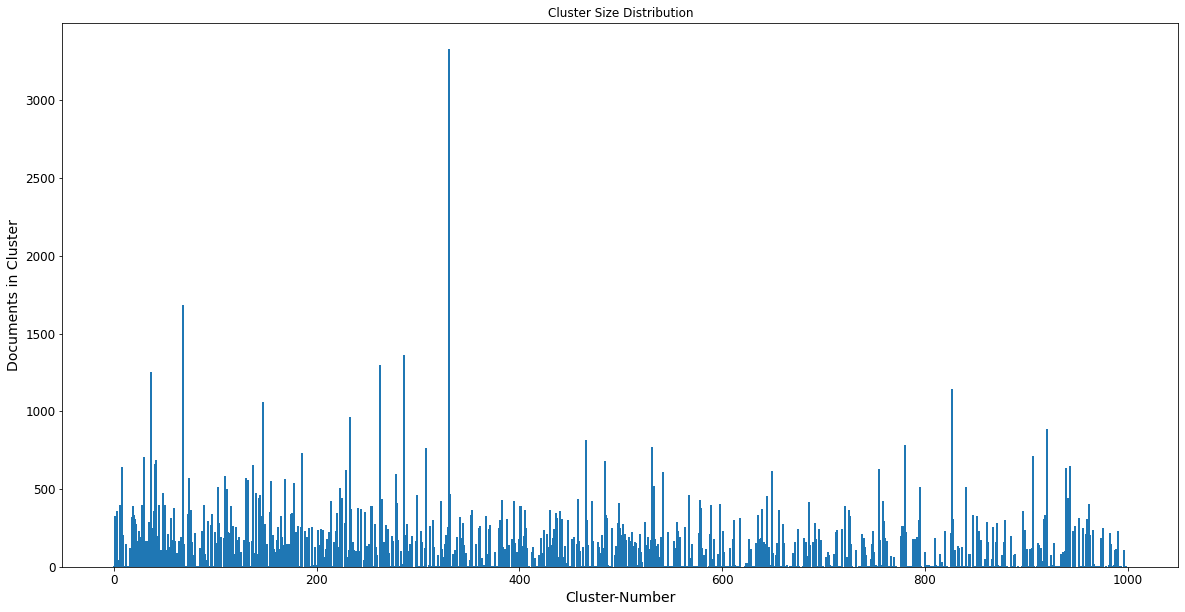


Finished running 'get_pairwise_dist' in 0.0001 mins


Number of Cluster Pairs : 499500

Finished running 'get_cluster_pairs' in 0.0012 mins

499500

Finished running 'cluster2doc' in 0.0004 mins


Finished running 'filter_clusters' in 0.1673 mins

Filtered CLustered Pairs : 5995


In [11]:
# Pipeline test
# path = "/data/3/karthik/preference_prediction/articles.csv"

# Pipeline test
path = "../articles.csv"

main_df = load_data(path)

sampled_df = sample_data(df=main_df,sample_size=0.2,seed=RANDOM_SEED)
print("Sampled Size: %s" %str(sampled_df.shape[0]))

sampled_df["processed_text"] = preprocess_texts(text_lists=sampled_df["text"])

vectors,vocab,tfidf_vectorizer = vectorization(df=sampled_df,min_df=50,max_df=0.75,seed=RANDOM_SEED)

reduced_vectors = dimensionality_reduction(vectors=vectors,mode="SVD_LSA",dim=500,seed=RANDOM_SEED)

## to choose k
num_clusters_sett = [500,1000,2000,3000]
f_cp_map = {}

clusters,cluster_clf = run_clustering(vectors=reduced_vectors,seed=RANDOM_SEED,num_clusters=1000,clus_type="kmeans")

# cluster_score = score_cluster(vectors,cluster_clf,score_type="sil_score")

cluster_sizes = get_cluster_sizes(cluster_clf)

plot_size_dist(cluster_sizes)

cluster_pair_dist_mat = get_pairwise_dist(cluster_clf,dist_type="cosine")

cluster_pairs = get_cluster_pairs(num_clusters=1000)
print(len(cluster_pairs))

doc_2_cluster_map = cluster2doc(num_texts=sampled_df.shape[0],cluster_labels=cluster_clf.labels_)

filtered_cluster_pairs = filter_clusters(cluster_pairs=cluster_pairs,
                                        doc_2_cluster_map=doc_2_cluster_map,
                                        cluster_sizes=cluster_sizes,
                                        partisan_scores=sampled_df["binary_ps"].tolist(),
                                        min_size=300,
                                        max_size=5000,
                                        min_partisan_size=0.3)

print("Filtered CLustered Pairs : %s" %str(len(filtered_cluster_pairs)))

In [12]:
top100 = get_top_100_clusterpairs(cluster_pairs=filtered_cluster_pairs,dist_matrix=cluster_pair_dist_mat,reverse=True)


Finished running 'get_top_100_clusterpairs' in 0.0002 mins



In [13]:
df_result = run_train_all(X = reduced_vectors,
                          cluster_2_doc_map = doc_2_cluster_map ,
                          df = sampled_df ,
                          cluster_pairs = top100,
                          cosine_mat = cluster_pair_dist_mat,
                          thresholds = [0.5,0.7,0.9],
                          user_type="Heterogeneous")

Training model for cluster pair : 0
Train Label Dist :
 0 : 203
 1:155
Test Label Dist :
 0.0 : 123
 1.0:201

Finished running 'create_train_test' in 0.0002 mins

(324, 2)

Finished running 'run_model' in 0.0049 mins

Training model for cluster pair : 1
Train Label Dist :
 0 : 221
 1:104
Test Label Dist :
 0.0 : 166
 1.0:176

Finished running 'create_train_test' in 0.0002 mins

(342, 2)

Finished running 'run_model' in 0.0054 mins

Training model for cluster pair : 2
Train Label Dist :
 0 : 328
 1:186
Test Label Dist :
 0.0 : 481
 1.0:404

Finished running 'create_train_test' in 0.0005 mins

(885, 2)

Finished running 'run_model' in 0.0072 mins

Training model for cluster pair : 3
Train Label Dist :
 0 : 774
 1:523
Test Label Dist :
 0.0 : 235
 1.0:395

Finished running 'create_train_test' in 0.0002 mins

(630, 2)

Finished running 'run_model' in 0.0216 mins

Training model for cluster pair : 4
Train Label Dist :
 0 : 274
 1:279
Test Label Dist :
 0.0 : 235
 1.0:395

Finished running '

In [14]:
# for threshold in [0.5,0.7,0.9]:
#     plot_sim_vs_score(df_result,threshold)

In [15]:
df_result_homog = run_train_all(X = reduced_vectors,
                          cluster_2_doc_map = doc_2_cluster_map ,
                          df = sampled_df ,
                          cluster_pairs = top100,
                          cosine_mat = cluster_pair_dist_mat,
                          thresholds = [0.5,0.7,0.9],
                          user_type="Homogeneous")

Training model for cluster pair : 0
Train Label Dist :
 0 : 203
 1:155
Test Label Dist :
 0 : 201
 1:123

Finished running 'create_train_test' in 0.0001 mins

(324, 2)

Finished running 'run_model' in 0.0041 mins

Training model for cluster pair : 1
Train Label Dist :
 0 : 221
 1:104
Test Label Dist :
 0 : 176
 1:166

Finished running 'create_train_test' in 0.0001 mins

(342, 2)

Finished running 'run_model' in 0.0066 mins

Training model for cluster pair : 2
Train Label Dist :
 0 : 328
 1:186
Test Label Dist :
 0 : 404
 1:481

Finished running 'create_train_test' in 0.0002 mins

(885, 2)

Finished running 'run_model' in 0.0080 mins

Training model for cluster pair : 3
Train Label Dist :
 0 : 774
 1:523
Test Label Dist :
 0 : 395
 1:235

Finished running 'create_train_test' in 0.0002 mins

(630, 2)

Finished running 'run_model' in 0.0220 mins

Training model for cluster pair : 4
Train Label Dist :
 0 : 274
 1:279
Test Label Dist :
 0 : 395
 1:235

Finished running 'create_train_test' i

In [16]:
# for threshold in [0.5,0.7,0.9]:
#     plot_sim_vs_score(df_result_homog,threshold)

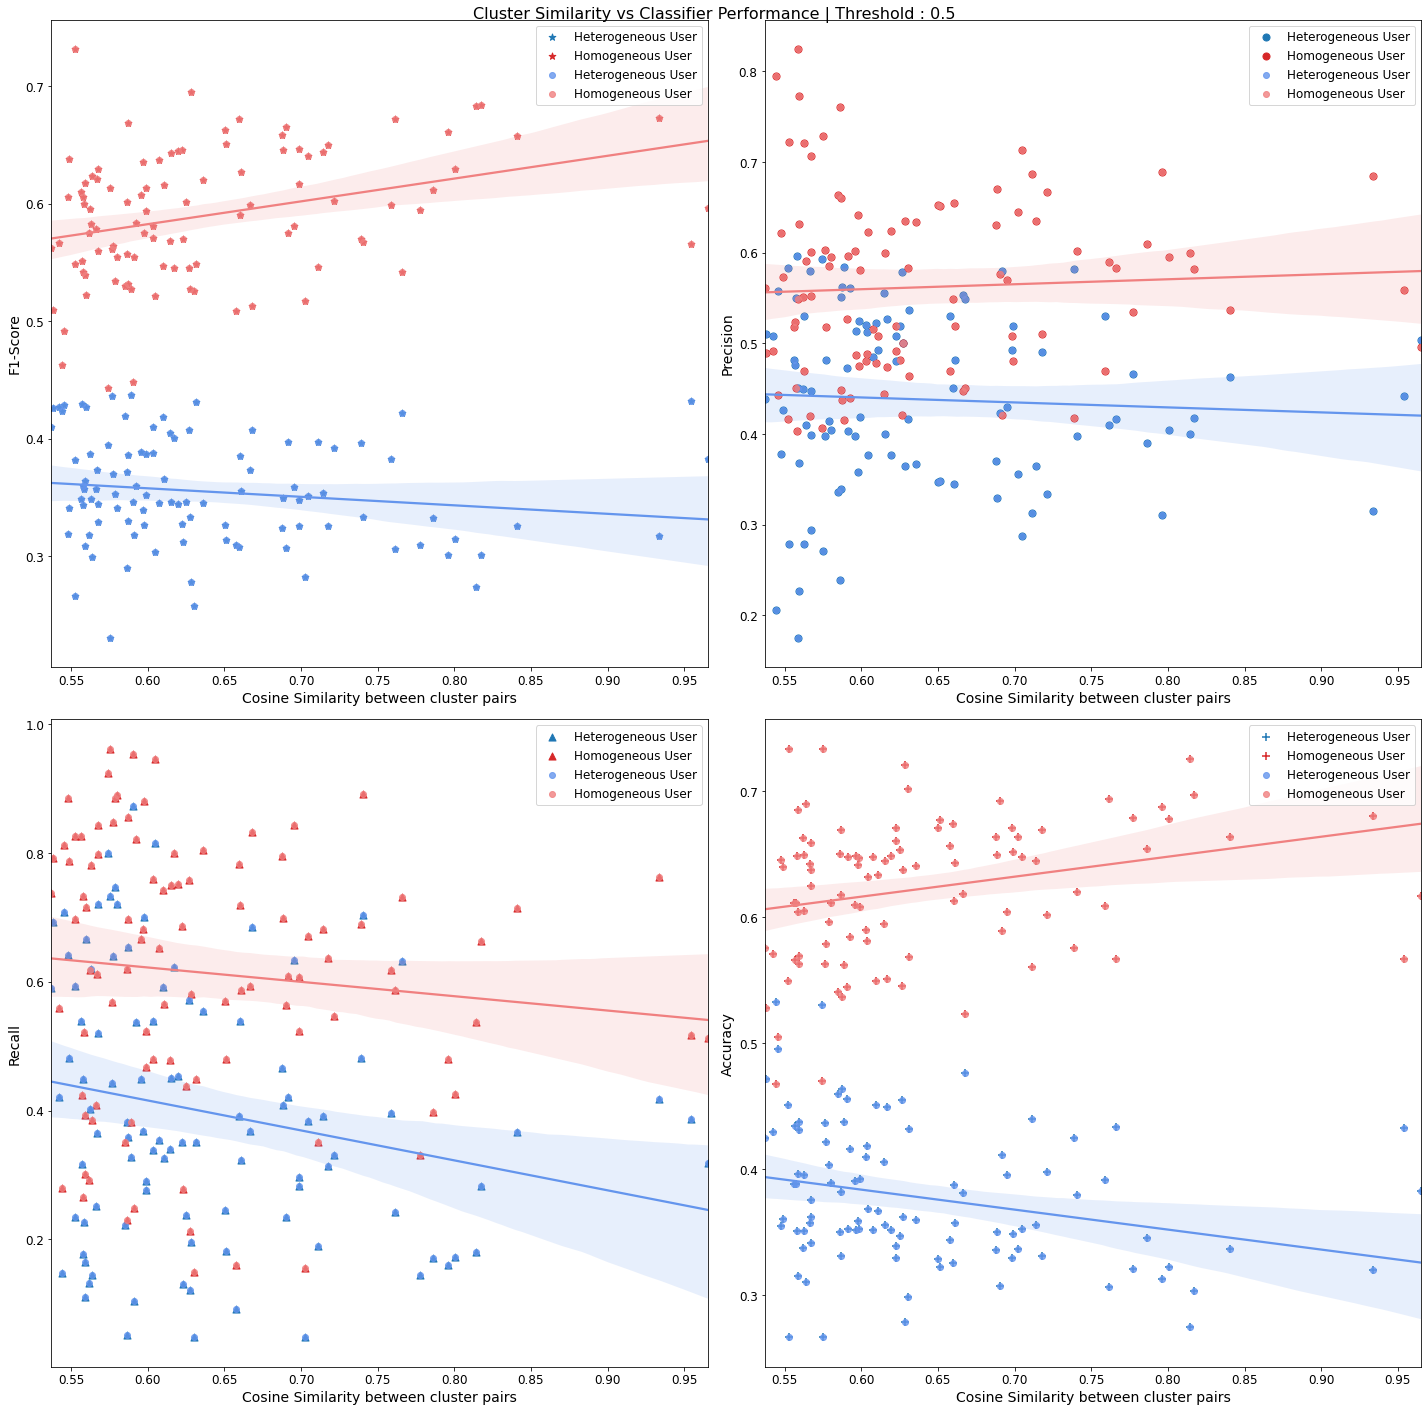


Finished running 'plot_sim_vs_score_all_users' in 0.0198 mins



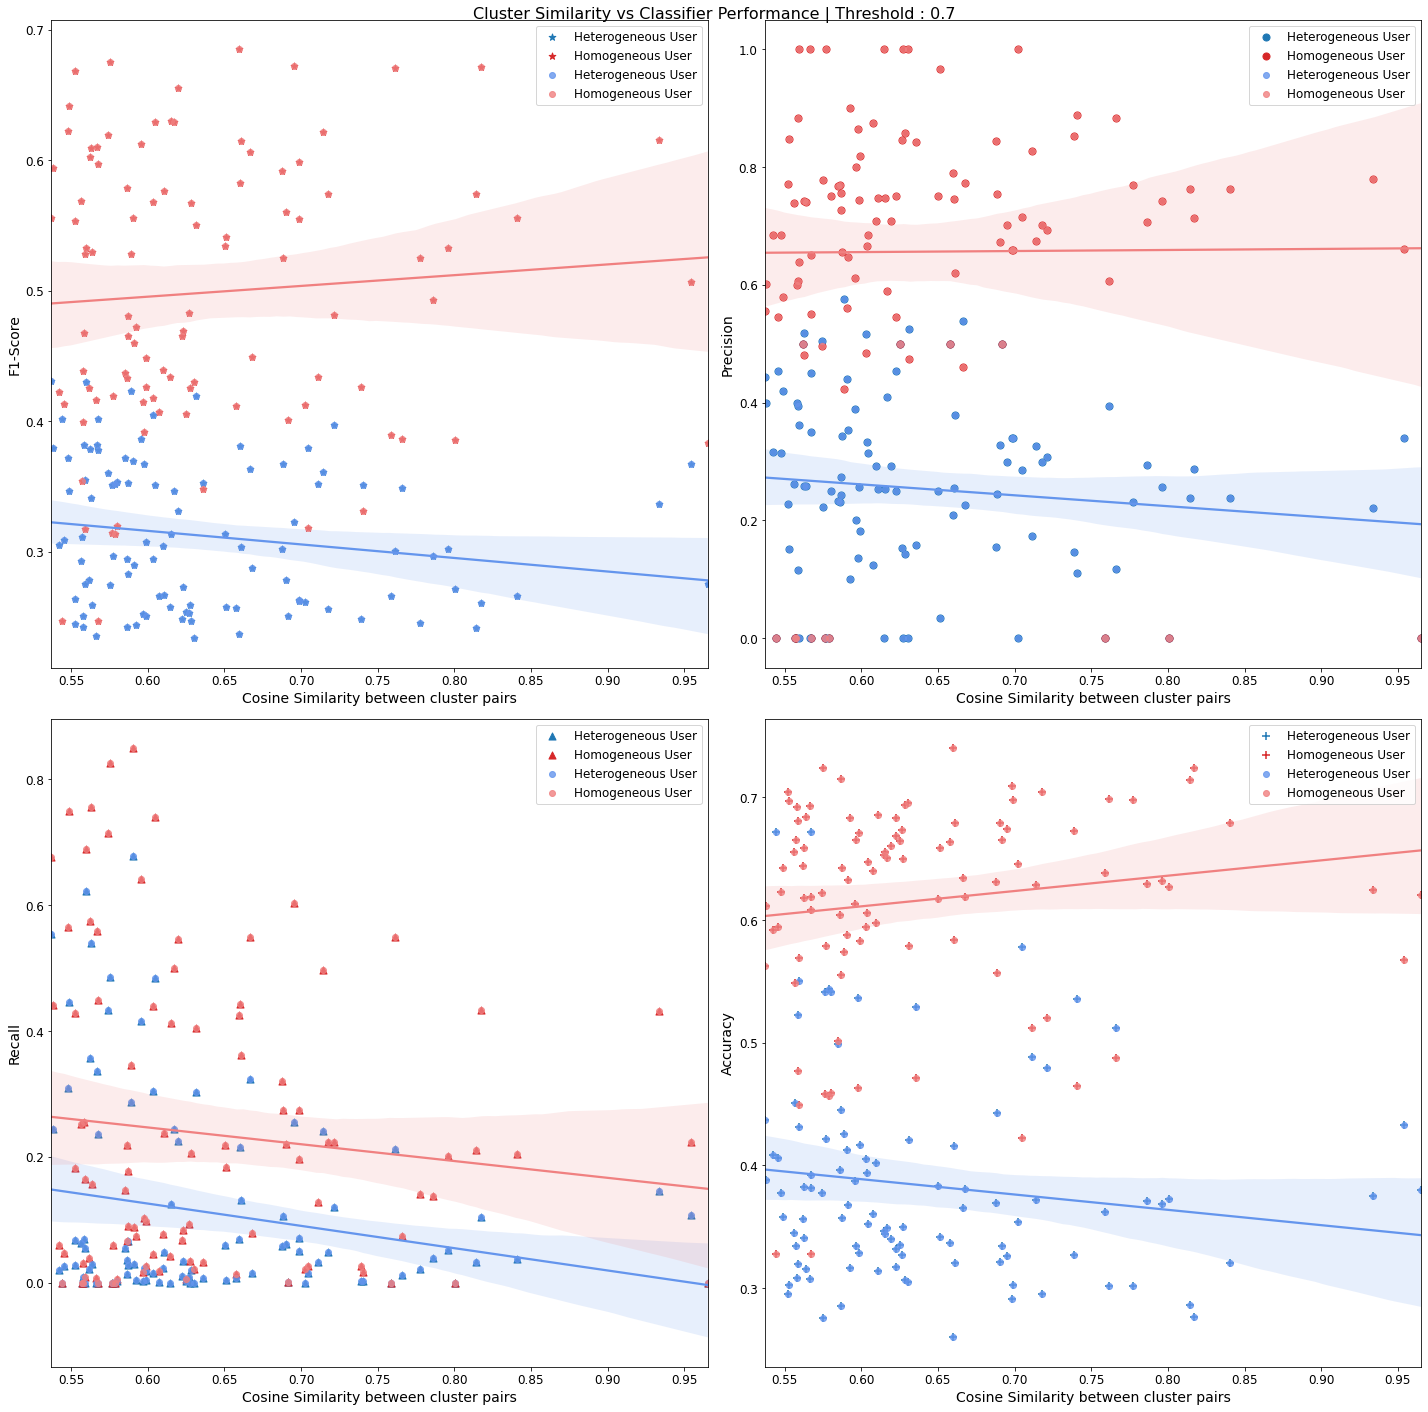


Finished running 'plot_sim_vs_score_all_users' in 0.0208 mins



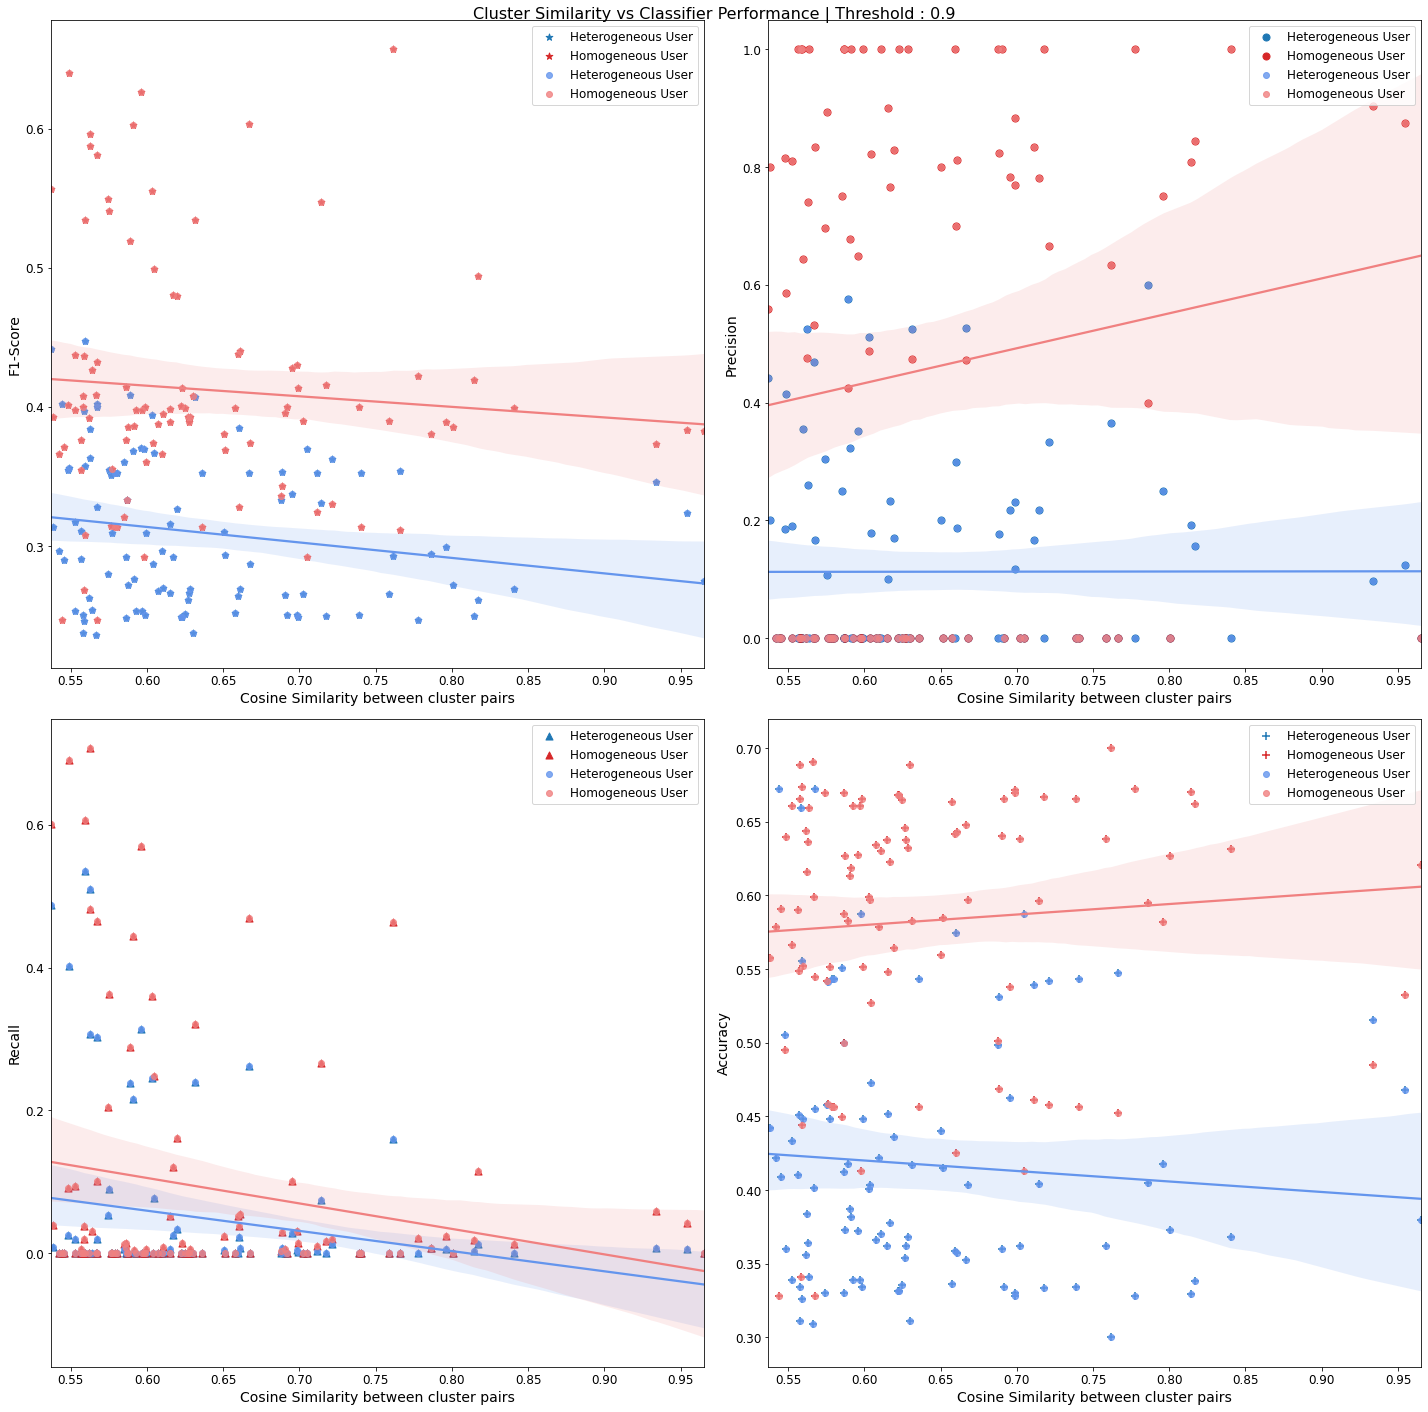


Finished running 'plot_sim_vs_score_all_users' in 0.0195 mins



In [17]:
for threshold in [0.5,0.7,0.9]:
    plot_sim_vs_score_all_users(df_results_hetero=df_result,
                                df_results_homo=df_result_homog,
                                threshold=threshold)

## Online Learning Setting

In [53]:
hetero_scores = run_online_setting(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                   user_type="Heterogeneous")

Training model for cluster pair : 0
Train Label Dist :
 0 : 203
 1:155
Test Label Dist :
 0.0 : 123
 1.0:201

Finished running 'create_train_test' in 0.0001 mins

Training model for cluster pair : 1
Train Label Dist :
 0 : 221
 1:104
Test Label Dist :
 0.0 : 166
 1.0:176

Finished running 'create_train_test' in 0.0001 mins

Training model for cluster pair : 2
Train Label Dist :
 0 : 328
 1:186
Test Label Dist :
 0.0 : 481
 1.0:404

Finished running 'create_train_test' in 0.0002 mins

Training model for cluster pair : 3
Train Label Dist :
 0 : 774
 1:523
Test Label Dist :
 0.0 : 235
 1.0:395

Finished running 'create_train_test' in 0.0002 mins

Training model for cluster pair : 4
Train Label Dist :
 0 : 274
 1:279
Test Label Dist :
 0.0 : 235
 1.0:395

Finished running 'create_train_test' in 0.0001 mins

Training model for cluster pair : 5
Train Label Dist :
 0 : 672
 1:388
Test Label Dist :
 0.0 : 1113
 1.0:2216

Finished running 'create_train_test' in 0.0005 mins

Training model for c

In [54]:
homo_scores =  run_online_setting(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                   user_type="Homogeneous")

Training model for cluster pair : 0
Train Label Dist :
 0 : 203
 1:155
Test Label Dist :
 0 : 201
 1:123

Finished running 'create_train_test' in 0.0001 mins

Training model for cluster pair : 1
Train Label Dist :
 0 : 221
 1:104
Test Label Dist :
 0 : 176
 1:166

Finished running 'create_train_test' in 0.0001 mins

Training model for cluster pair : 2
Train Label Dist :
 0 : 328
 1:186
Test Label Dist :
 0 : 404
 1:481

Finished running 'create_train_test' in 0.0001 mins

Training model for cluster pair : 3
Train Label Dist :
 0 : 774
 1:523
Test Label Dist :
 0 : 395
 1:235

Finished running 'create_train_test' in 0.0002 mins

Training model for cluster pair : 4
Train Label Dist :
 0 : 274
 1:279
Test Label Dist :
 0 : 395
 1:235

Finished running 'create_train_test' in 0.0001 mins

Training model for cluster pair : 5
Train Label Dist :
 0 : 672
 1:388
Test Label Dist :
 0 : 2216
 1:1113

Finished running 'create_train_test' in 0.0003 mins

Training model for cluster pair : 6
Train La

In [55]:
hetero_scores.keys()

dict_keys([(3, 146), (1, 175), (795, 920), (262, 755), (155, 755), (147, 330), (448, 755), (155, 448), (74, 262), (467, 759), (175, 353), (39, 755), (725, 795), (725, 920), (36, 330), (1, 353), (330, 907), (542, 780), (656, 920), (176, 952), (656, 795), (233, 330), (147, 233), (154, 440), (40, 330), (579, 795), (579, 920), (330, 780), (40, 262), (132, 330), (74, 755), (1, 952), (233, 879), (262, 383), (579, 725), (579, 656), (430, 920), (39, 262), (262, 612), (330, 331), (330, 341), (36, 40), (36, 233), (74, 383), (40, 962), (147, 780), (233, 567), (137, 430), (36, 341), (383, 755), (36, 533), (36, 147), (353, 952), (36, 262), (76, 143), (401, 498), (262, 330), (175, 952), (40, 907), (39, 155), (36, 907), (147, 943), (49, 155), (225, 278), (40, 755), (248, 780), (330, 759), (656, 725), (74, 598), (897, 920), (589, 920), (430, 656), (279, 367), (155, 828), (49, 755), (6, 381), (279, 918), (39, 448), (36, 144), (795, 897), (132, 918), (132, 147), (383, 405), (132, 279), (176, 598), (147,

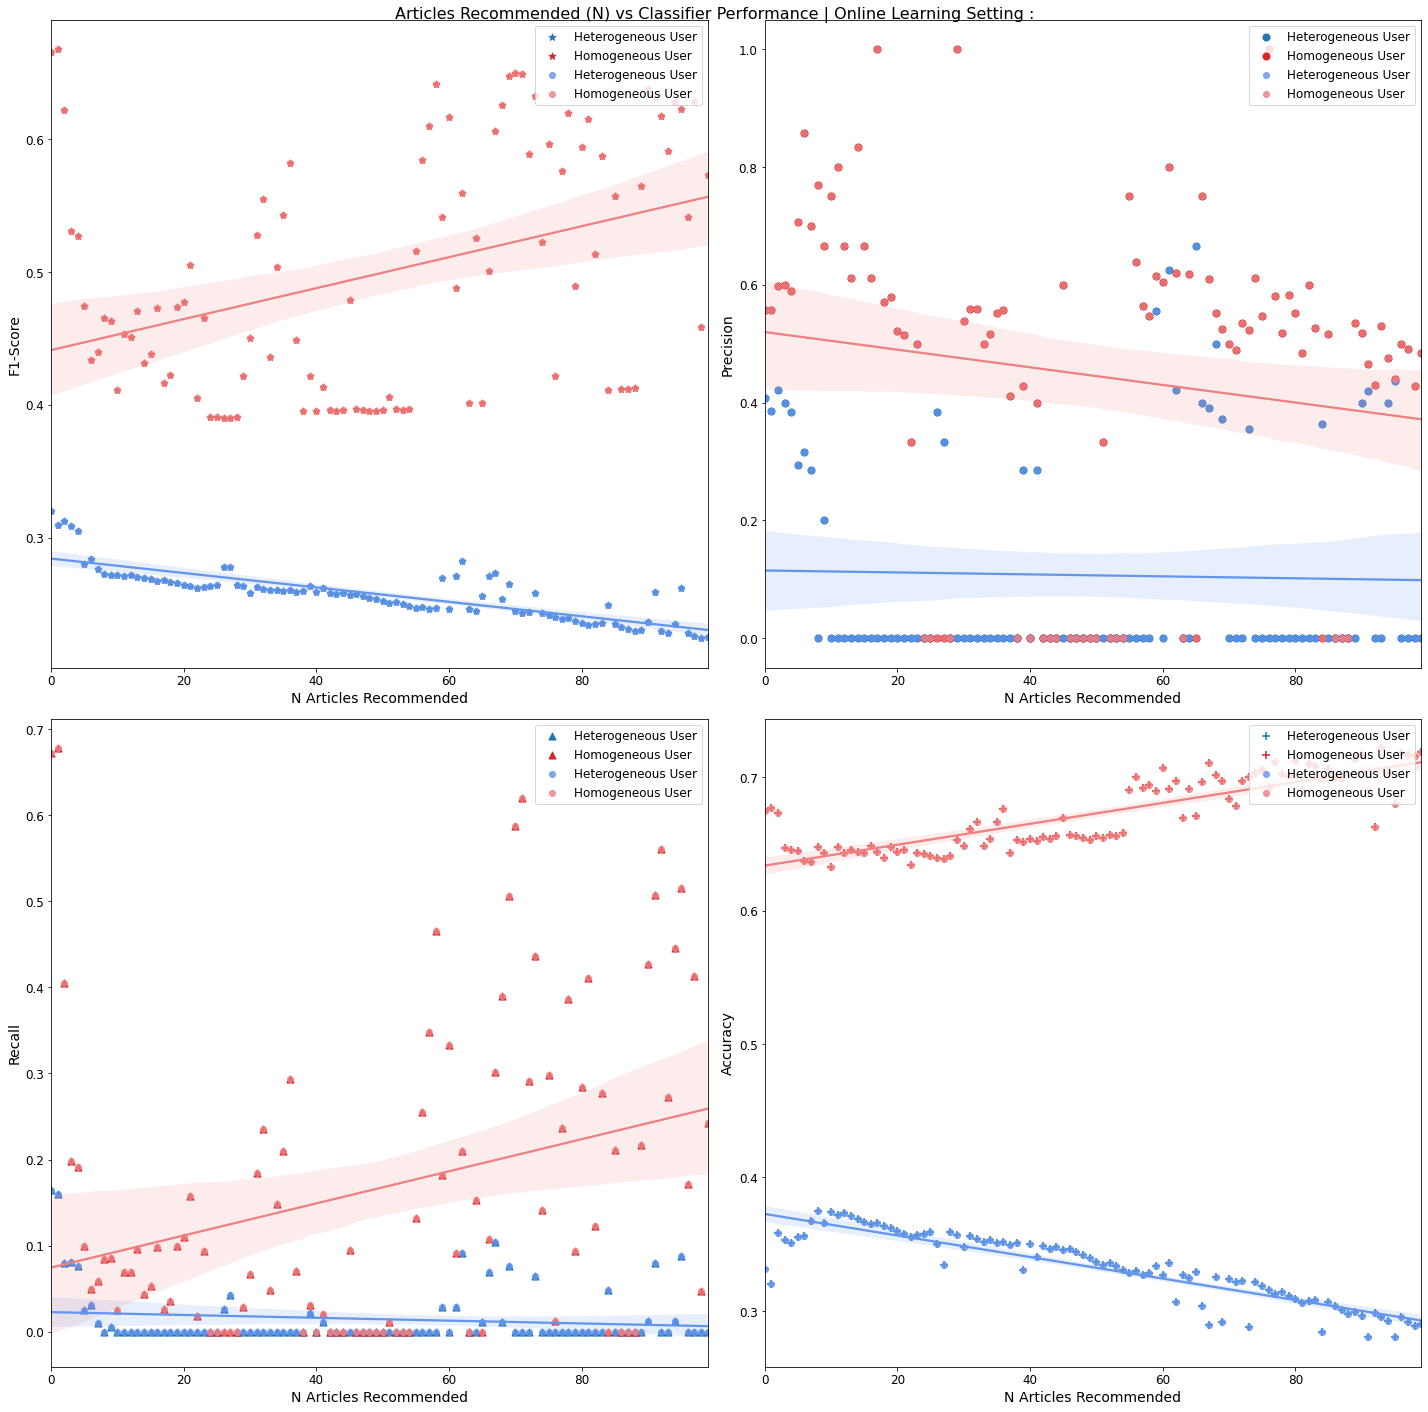


Finished running 'plot_online_setting_per_clusterpair' in 0.0167 mins



In [69]:
plot_online_setting_per_clusterpair(homo_scores[(3,146)],hetero_scores[(3,146)])

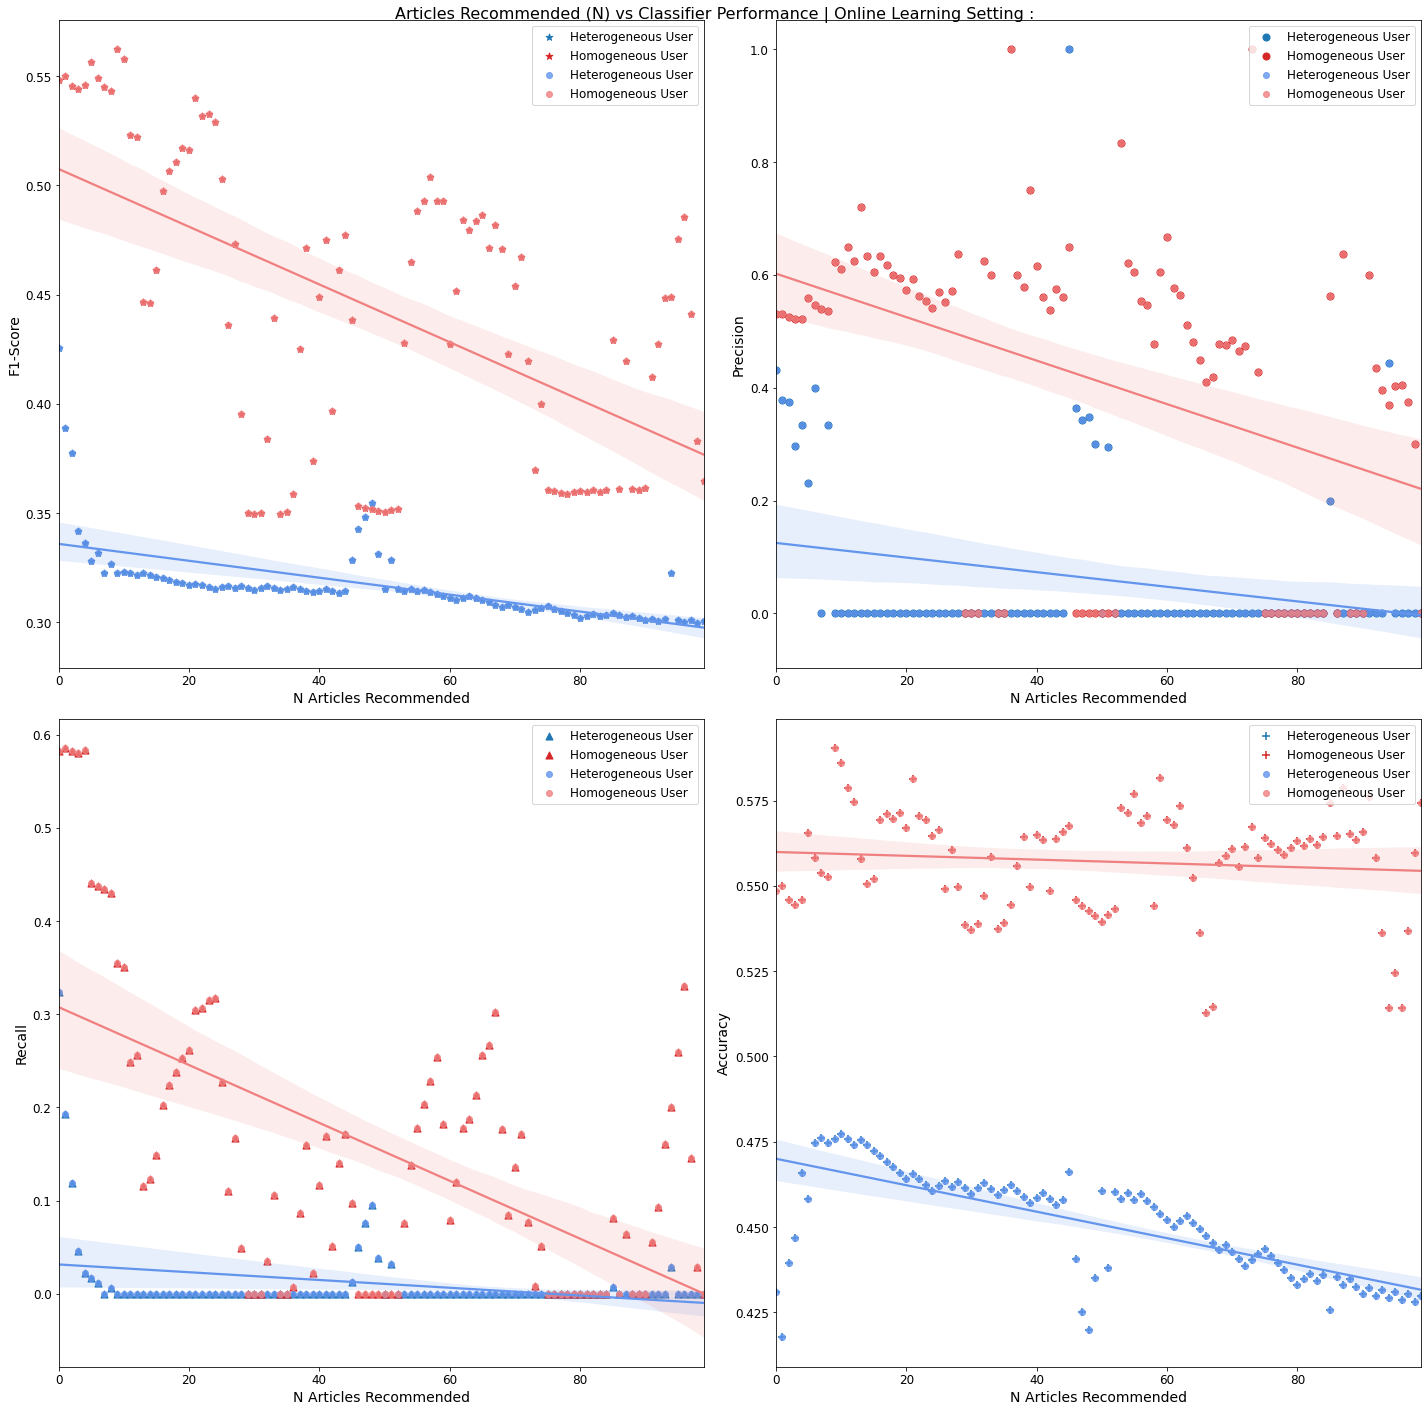


Finished running 'plot_online_setting_per_clusterpair' in 0.0188 mins



In [68]:
plot_online_setting_per_clusterpair(homo_scores[(1, 175)],hetero_scores[(1, 175)])


Finished running 'combine_scores_cumu_online_setting' in 0.0001 mins


Finished running 'combine_scores_cumu_online_setting' in 0.0000 mins



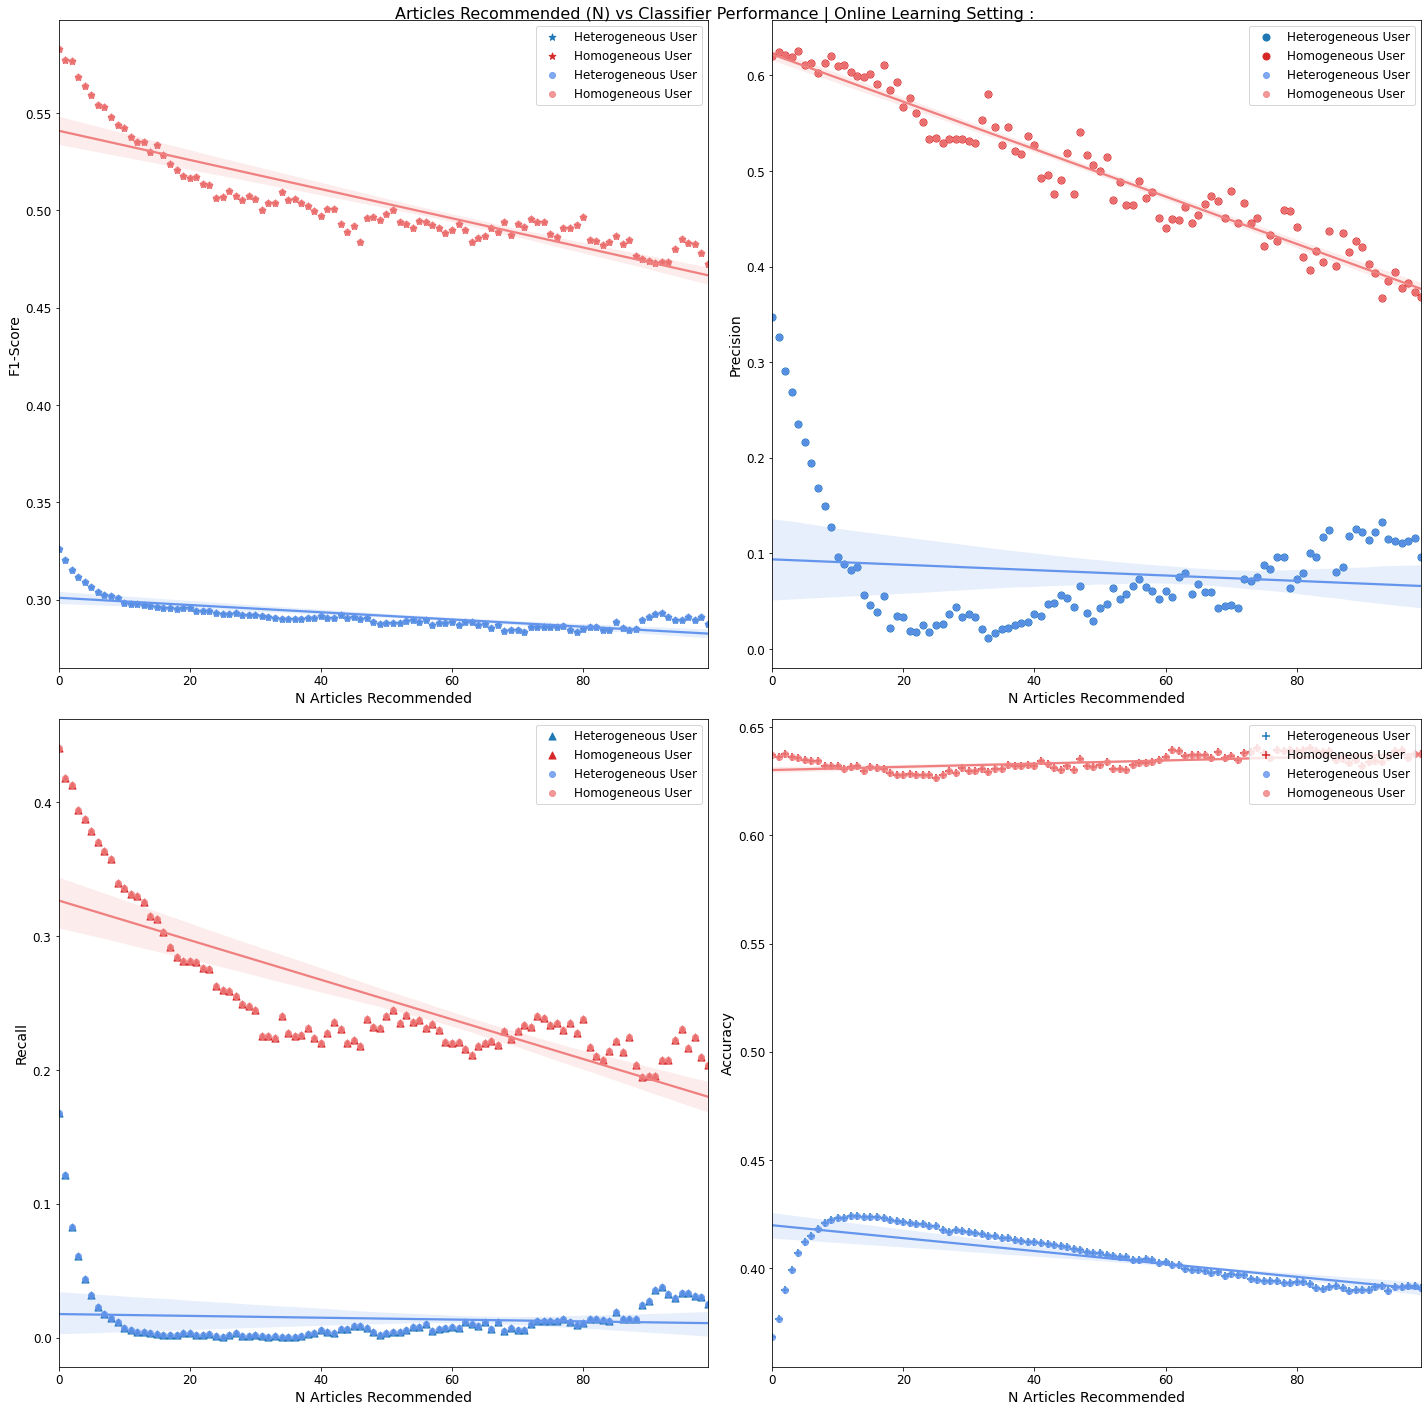


Finished running 'plot_online_setting_per_clusterpair' in 0.0170 mins


Finished running 'plot_online_learning_cumulative' in 0.0171 mins



In [67]:
plot_online_learning_cumulative(homo_scores,hetero_scores)